Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1273s 27s/step - accuracy: 0.8500 - loss: 0.4542 - val_accuracy: 0.9602 - val_loss: 1.1795
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1155s 26s/step - accuracy: 0.9569 - loss: 0.2245 - val_accuracy: 0.8608 - val_loss: 5.6131
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1001s 22s/step - accuracy: 0.9778 - loss: 0.0810 - val_accuracy: 0.9517 - val_loss: 1.1735
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 979s 22s/step - accuracy: 0.9576 - loss: 0.2471 - val_accuracy: 0.9403 - val_loss: 0.6431
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 971s 22s/step - accuracy: 0.9653 - loss: 0.1918 - val_accuracy: 0.6790 - val_loss: 14.9544
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 966s 21s/step - accuracy: 0.9854 - loss: 0.0800 - val_accuracy: 0.7756 - val_loss: 4.8160
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 974s 22s/step - accuracy: 0.9736 - loss: 0.1744 - val_accuracy: 0.9688 - val_loss: 0.0944
Epoch 8/30
45/45 

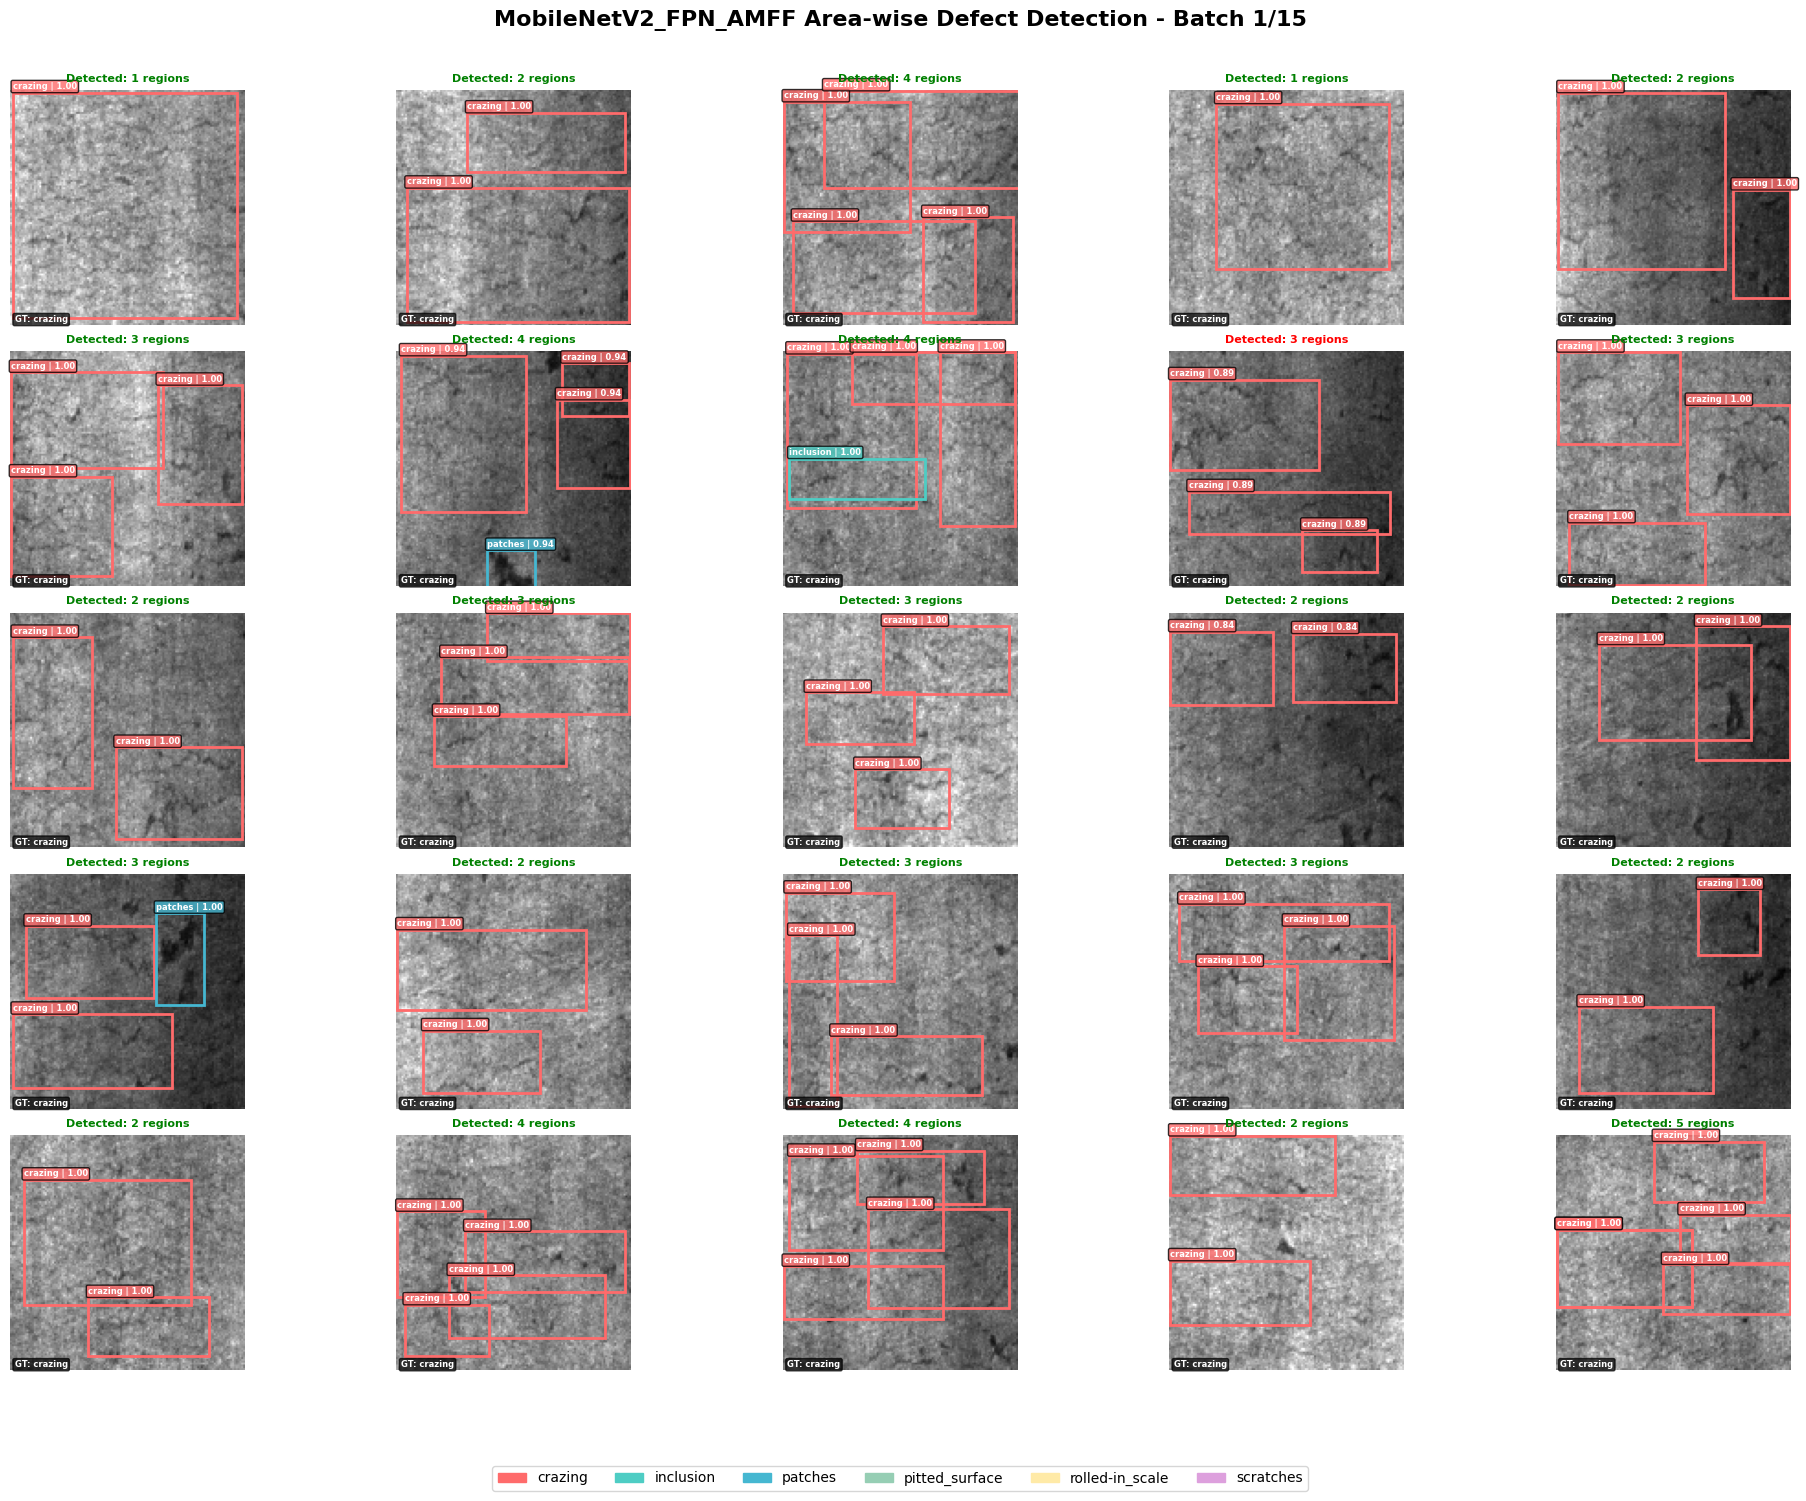

Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_2.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_3.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_4.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_5.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_6.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_7.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\MobileNetV2_FPN_AMFF_detection_batch_8.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_De

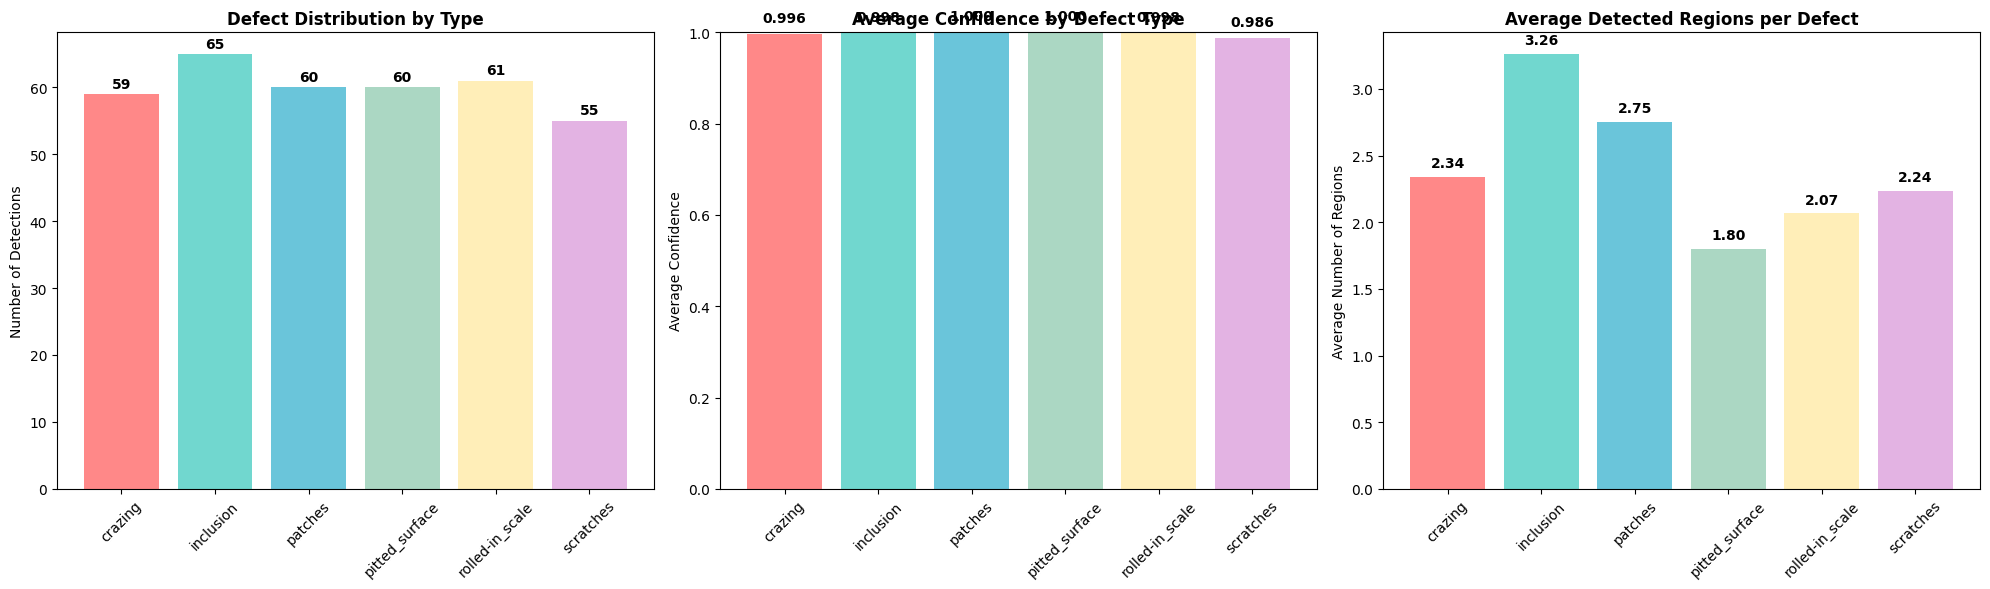


Model Performance Summary
Final Validation Accuracy: 0.9858
Final Validation Loss: 0.0787
Total predictions analyzed: 360
Total defect regions detected: 872
Average regions per image: 2.42

Training history saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\mobilenetv2_fpn_amff_training_history.png


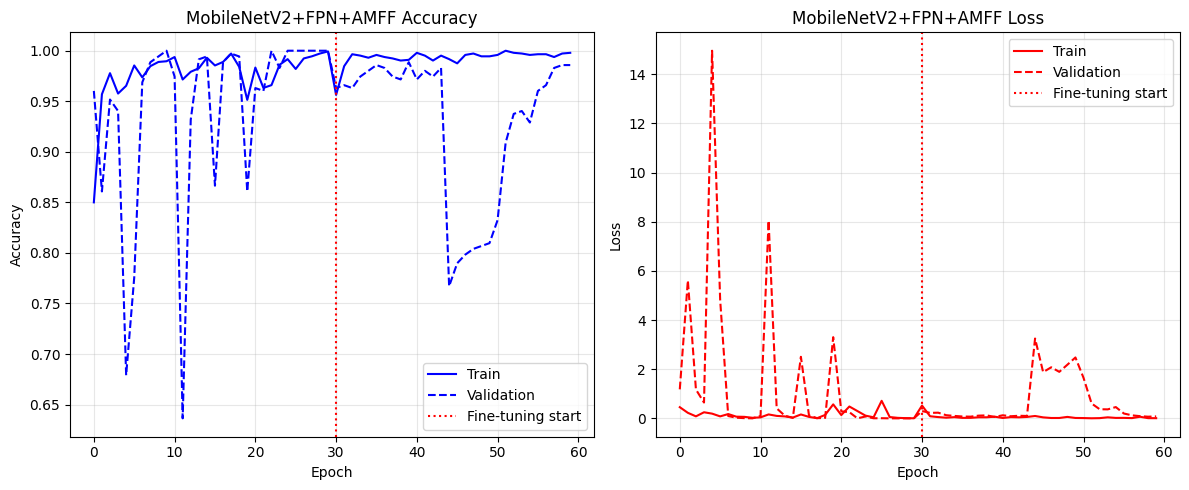


Final model saved at: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\mobilenetv2_fpn_amff_model.h5


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math
import cv2
import json
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore')


img_size = 128
batch_size = 32
epochs = 60

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
num_classes = len(class_names)
input_shape = (img_size, img_size, 3)


images_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\NEU-DET\IMAGES"
annotations_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\NEU-DET\ANNOTATIONS"
output_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1"

os.makedirs(output_dir, exist_ok=True)

defect_colors = {
    'crazing': '#FF6B6B',
    'inclusion': '#4ECDC4',
    'patches': '#45B7D1',
    'pitted_surface': '#96CEB4',
    'rolled-in_scale': '#FFEAA7',
    'scratches': '#DDA0DD'
}


class AMFF(layers.Layer):
    """
    Attention-based Multi-scale Feature Fusion
    Replaces simple addition in FPN to strengthen defect features
    """
    def __init__(self, filters, **kwargs):
        super(AMFF, self).__init__(**kwargs)
        self.filters = filters
        
    def build(self, input_shape):
       
        self.global_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.fc1 = layers.Dense(self.filters // 4, activation='relu')
        self.fc2 = layers.Dense(self.filters, activation='sigmoid')
        
        
        self.conv_spatial = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        
        
        self.conv_fusion = layers.Conv2D(self.filters, 1, padding='same')
        self.bn = layers.BatchNormalization()
        
    def call(self, inputs):
        """
        inputs: list of [higher_level_feature, lower_level_feature]
        """
        high_feat, low_feat = inputs
        
       
        high_feat_resized = tf.image.resize(high_feat, tf.shape(low_feat)[1:3])
        
      
        channel_attention = self.global_pool(high_feat_resized)
        channel_attention = self.fc1(channel_attention)
        channel_attention = self.fc2(channel_attention)
        high_feat_channel = high_feat_resized * channel_attention
        
       
        spatial_map = tf.concat([
            tf.reduce_max(high_feat_resized, axis=-1, keepdims=True),
            tf.reduce_mean(high_feat_resized, axis=-1, keepdims=True)
        ], axis=-1)
        spatial_attention = self.conv_spatial(spatial_map)
        high_feat_spatial = high_feat_resized * spatial_attention
        
       
        fused = tf.concat([high_feat_channel, high_feat_spatial, low_feat], axis=-1)
        output = self.conv_fusion(fused)
        output = self.bn(output)
        output = tf.nn.relu(output)
        
        return output



class FPN(layers.Layer):
    def __init__(self, **kwargs):
        super(FPN, self).__init__(**kwargs)
        
    def build(self, input_shape):
     
        self.lateral_c5 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c4 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c3 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c2 = layers.Conv2D(256, 1, padding='same')
        
     
        self.amff_p4 = AMFF(256)
        self.amff_p3 = AMFF(256)
        self.amff_p2 = AMFF(256)
        
       
        self.smooth_p4 = layers.Conv2D(256, 3, padding='same')
        self.smooth_p3 = layers.Conv2D(256, 3, padding='same')
        self.smooth_p2 = layers.Conv2D(256, 3, padding='same')
        
    def call(self, features):
        """
        features: dict with keys 'C2', 'C3', 'C4', 'C5' (multi-level features)
        returns: dict with keys 'P2', 'P3', 'P4', 'P5' (pyramid features)
        """
        c2, c3, c4, c5 = features['C2'], features['C3'], features['C4'], features['C5']
        
        
        p5 = self.lateral_c5(c5)
        
        p4 = self.amff_p4([p5, self.lateral_c4(c4)])
        p4 = self.smooth_p4(p4)
        
        p3 = self.amff_p3([p4, self.lateral_c3(c3)])
        p3 = self.smooth_p3(p3)
        
        p2 = self.amff_p2([p3, self.lateral_c2(c2)])
        p2 = self.smooth_p2(p2)
        
        return {'P2': p2, 'P3': p3, 'P4': p4, 'P5': p5}



def build_mobilenetv2_fpn_model(input_shape=(128, 128, 3), num_classes=6):
    """
    Build model with MobileNetV2 + FPN + AMFF
    Architecture:
    - Backbone: MobileNetV2 (extracts C2-C5 features)
    - Neck: FPN with AMFF for multi-scale fusion
    - Head: Classification head (Faster R-CNN based)
    """
    inputs = layers.Input(shape=input_shape)
    

    backbone = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    backbone.trainable = False 
    

    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
    

    c2 = backbone.get_layer('block_1_expand_relu').output  # 64x64
    c3 = backbone.get_layer('block_3_expand_relu').output  # 32x32
    c4 = backbone.get_layer('block_6_expand_relu').output  # 16x16
    c5 = backbone.output  # 4x4
    
   
    feature_extractor = Model(
        inputs=backbone.input,
        outputs={'C2': c2, 'C3': c3, 'C4': c4, 'C5': c5}
    )
    
    features = feature_extractor(x)
    

    fpn = FPN()
    pyramid_features = fpn(features)
    

    p2 = pyramid_features['P2']
    

    p2_pooled = layers.GlobalAveragePooling2D()(p2)
    

    x = layers.Dense(256, activation='relu')(p2_pooled)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, backbone



def load_annotations(annotations_dir, img_filename, original_size, target_size):
    """Load annotations from JSON/XML/TXT formats"""
    base_name = os.path.splitext(img_filename)[0]
    regions = []
    

    json_path = os.path.join(annotations_dir, base_name + '.json')
    if os.path.exists(json_path):
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            boxes = data.get('boxes', [])
            labels = data.get('labels', [])
            
            scale_x = target_size[1] / original_size[1]
            scale_y = target_size[0] / original_size[0]
            
            for i, box in enumerate(boxes):
                x, y, w, h = box
                scaled_box = [
                    int(x * scale_x),
                    int(y * scale_y),
                    int(w * scale_x),
                    int(h * scale_y)
                ]
                regions.append({
                    'bbox': scaled_box,
                    'label': labels[i] if i < len(labels) else 'unknown',
                    'area': scaled_box[2] * scaled_box[3]
                })
            return regions
        except Exception as e:
            print(f"Error loading JSON: {e}")
    
    
    xml_path = os.path.join(annotations_dir, base_name + '.xml')
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            size = root.find('size')
            orig_w = int(size.find('width').text)
            orig_h = int(size.find('height').text)
            
            scale_x = target_size[1] / orig_w
            scale_y = target_size[0] / orig_h
            
            for obj in root.findall('object'):
                label = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = int(float(bbox.find('xmin').text) * scale_x)
                ymin = int(float(bbox.find('ymin').text) * scale_y)
                xmax = int(float(bbox.find('xmax').text) * scale_x)
                ymax = int(float(bbox.find('ymax').text) * scale_y)
                
                w = xmax - xmin
                h = ymax - ymin
                
                regions.append({
                    'bbox': [xmin, ymin, w, h],
                    'label': label,
                    'area': w * h
                })
            return regions
        except Exception as e:
            print(f"Error loading XML: {e}")
    
    return None


def detect_defect_regions_with_annotations(image, img_filename, predicted_class):
    regions = load_annotations(annotations_dir, img_filename, 
                              (image.shape[0], image.shape[1]), 
                              (img_size, img_size))
    
    if regions is not None and len(regions) > 0:
        return regions
    
   
    h, w = image.shape[:2]
    img_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)
    
    kernel = np.ones((5,5), np.uint8)
    morphed = cv2.morphologyEx(binary_inv, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)
    
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            regions.append({
                'bbox': [x, y, w, h],
                'label': predicted_class,
                'area': area
            })
    
    if not regions:
        regions = [{'bbox': [0, 0, w, h], 'label': predicted_class, 'area': w*h}]
    
    return regions


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size


def get_predictions_with_detection(model, generator, class_names):

    generator.reset()
    predictions = []
    total = min(generator.samples, 500)
    
    filenames = generator.filenames
    
    for i in range(min(len(generator), 20)):
        images, labels = generator[i]
        
        for j in range(len(images)):
            if len(predictions) >= total:
                break
            
            img = images[j]
            img_idx = i * generator.batch_size + j
            img_filename = os.path.basename(filenames[img_idx]) if img_idx < len(filenames) else f"img_{img_idx}.jpg"
            
            true_label = class_names[np.argmax(labels[j])]
            
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = class_names[np.argmax(pred[0])]
            confidence = np.max(pred[0])
            
            regions = detect_defect_regions_with_annotations(img, img_filename, pred_label)
            
            predictions.append({
                'image': img,
                'filename': img_filename,
                'true_label': true_label,
                'pred_label': pred_label,
                'confidence': confidence,
                'regions': regions
            })
        
        if len(predictions) >= total:
            break
    
    return predictions


def create_detection_visualization(predictions, model_name, batch_size=25, display_limit=10):

    total_images = len(predictions)
    batches = math.ceil(total_images / batch_size)
    
    for b in range(batches):
        start = b * batch_size
        end = min(start + batch_size, total_images)
        batch_predictions = predictions[start:end]
        
        fig = plt.figure(figsize=(20, 16))
        fig.patch.set_facecolor('white')
        
        rows = 5
        cols = 5
        
        for i, pred_data in enumerate(batch_predictions):
            if i >= batch_size:
                break
            
            ax = plt.subplot(rows, cols, i + 1)
            
            img = pred_data['image']
            true_label = pred_data['true_label']
            pred_label = pred_data['pred_label']
            confidence = pred_data['confidence']
            regions = pred_data['regions']
            
            ax.imshow(img)
            
            for region in regions[:5]:
                bbox = region['bbox']
                x, y, w, h = bbox
                region_label = region.get('label', pred_label)
                
                color = defect_colors.get(region_label, '#FF0000')
                rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                label_text = f"{region_label} | {confidence:.2f}"
                ax.text(x, y-2, label_text, fontsize=6, color='white', 
                       fontweight='bold', bbox=dict(boxstyle="round,pad=0.2", 
                       facecolor=color, alpha=0.8))
            
            is_correct = (true_label == pred_label)
            title_color = 'green' if is_correct else 'red'
            ax.set_title(f"Detected: {len(regions)} regions", 
                        fontsize=8, color=title_color, fontweight='bold')
            
            ax.text(2, img.shape[0]-2, f"GT: {true_label}", fontsize=6, 
                   color='white', fontweight='bold', 
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7))
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
        plt.suptitle(f'{model_name} Area-wise Defect Detection - Batch {b+1}/{batches}', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        legend_elements = [patches.Patch(color=color, label=defect) 
                          for defect, color in defect_colors.items()]
        plt.figlegend(handles=legend_elements, loc='lower center', 
                     ncol=len(class_names), fontsize=10, bbox_to_anchor=(0.5, 0.02))
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.90, bottom=0.1)
        
        save_path = os.path.join(output_dir, f'{model_name}_detection_batch_{b+1}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
        
        if b == 0 and display_limit > 0:
            plt.show()
        else:
            plt.close()


def create_area_analysis(predictions, class_names, model_name):
    """Create area-wise analysis charts"""
    area_stats = {class_name: {'count': 0, 'total_confidence': 0, 'total_regions': 0} 
                  for class_name in class_names}
    
    for pred_data in predictions:
        pred_label = pred_data['pred_label']
        confidence = pred_data['confidence']
        num_regions = len(pred_data['regions'])
        
        area_stats[pred_label]['count'] += 1
        area_stats[pred_label]['total_confidence'] += confidence
        area_stats[pred_label]['total_regions'] += num_regions
    
    for class_name in area_stats:
        if area_stats[class_name]['count'] > 0:
            area_stats[class_name]['avg_confidence'] = area_stats[class_name]['total_confidence'] / area_stats[class_name]['count']
            area_stats[class_name]['avg_regions'] = area_stats[class_name]['total_regions'] / area_stats[class_name]['count']
        else:
            area_stats[class_name]['avg_confidence'] = 0
            area_stats[class_name]['avg_regions'] = 0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    classes = list(area_stats.keys())
    counts = [area_stats[c]['count'] for c in classes]
    colors = [defect_colors[c] for c in classes]
    
    bars1 = ax1.bar(classes, counts, color=colors, alpha=0.8)
    ax1.set_title('Defect Distribution by Type', fontweight='bold')
    ax1.set_ylabel('Number of Detections')
    ax1.tick_params(axis='x', rotation=45)
    for bar, count in zip(bars1, counts):
        if count > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom', fontweight='bold')
    
    avg_confidences = [area_stats[c]['avg_confidence'] for c in classes]
    bars2 = ax2.bar(classes, avg_confidences, color=colors, alpha=0.8)
    ax2.set_title('Average Confidence by Defect Type', fontweight='bold')
    ax2.set_ylabel('Average Confidence')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    for bar, conf in zip(bars2, avg_confidences):
        if conf > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    avg_regions = [area_stats[c]['avg_regions'] for c in classes]
    bars3 = ax3.bar(classes, avg_regions, color=colors, alpha=0.8)
    ax3.set_title('Average Detected Regions per Defect', fontweight='bold')
    ax3.set_ylabel('Average Number of Regions')
    ax3.tick_params(axis='x', rotation=45)
    for bar, reg in zip(bars3, avg_regions):
        if reg > 0:
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                    f'{reg:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, f'{model_name}_area_analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()



model, base_model = build_mobilenetv2_fpn_model(input_shape=input_shape, num_classes=num_classes)


history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs // 2,
    verbose=1
)

print("\n" + "="*70)
print("Phase 2: Fine-tuning - Unfreezing top layers of MobileNetV2")
print("="*70)


base_model.trainable = True


for layer in base_model.layers[:-30]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs // 2,
    verbose=1
)

# Combine histories
history = type('History', (), {})()
history.history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

# Evaluate model
print("\nEvaluating model...")
val_loss, val_acc = model.evaluate(val_generator, steps=validation_steps, verbose=0)

print("\nGenerating predictions with area-wise detection...")
predictions = get_predictions_with_detection(model, val_generator, class_names)

print("\nCreating area-wise detection visualization...")
create_detection_visualization(predictions, "MobileNetV2_FPN_AMFF", batch_size=25, display_limit=10)

print("\nCreating comprehensive area-wise defect analysis...")
create_area_analysis(predictions, class_names, "MobileNetV2_FPN_AMFF")

print("\n" + "="*70)
print("Model Performance Summary")
print("="*70)
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Total predictions analyzed: {len(predictions)}")
total_regions = sum([len(p['regions']) for p in predictions])
print(f"Total defect regions detected: {total_regions}")
print(f"Average regions per image: {total_regions/len(predictions):.2f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='Train', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', color='blue', linestyle='--')
ax1.axvline(x=epochs//2, color='red', linestyle=':', label='Fine-tuning start')
ax1.set_title('MobileNetV2+FPN+AMFF Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', color='red')
ax2.plot(history.history['val_loss'], label='Validation', color='red', linestyle='--')
ax2.axvline(x=epochs//2, color='red', linestyle=':', label='Fine-tuning start')
ax2.set_title('MobileNetV2+FPN+AMFF Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save_path = os.path.join(output_dir, 'mobilenetv2_fpn_amff_training_history.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\nTraining history saved: {save_path}")
plt.show()

# Save the final model
final_model_path = os.path.join(output_dir, "mobilenetv2_fpn_amff_model.h5")
model.save(final_model_path)
print(f"\nFinal model saved at: {final_model_path}")



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import json

img_size = 128
batch_size = 32

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
num_classes = len(class_names)

images_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\NEU-DET\IMAGES"
output_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1"
model_path = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\mobilenetv2_fpn_amff_model.h5"

class AMFF(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AMFF, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.global_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.fc1 = layers.Dense(self.filters // 4, activation='relu')
        self.fc2 = layers.Dense(self.filters, activation='sigmoid')
        self.conv_spatial = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        self.conv_fusion = layers.Conv2D(self.filters, 1, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs):
        high_feat, low_feat = inputs
        high_feat_resized = tf.image.resize(high_feat, tf.shape(low_feat)[1:3])
        channel_attention = self.global_pool(high_feat_resized)
        channel_attention = self.fc1(channel_attention)
        channel_attention = self.fc2(channel_attention)
        high_feat_channel = high_feat_resized * channel_attention
        spatial_map = tf.concat([
            tf.reduce_max(high_feat_resized, axis=-1, keepdims=True),
            tf.reduce_mean(high_feat_resized, axis=-1, keepdims=True)
        ], axis=-1)
        spatial_attention = self.conv_spatial(spatial_map)
        high_feat_spatial = high_feat_resized * spatial_attention
        fused = tf.concat([high_feat_channel, high_feat_spatial, low_feat], axis=-1)
        output = self.conv_fusion(fused)
        output = self.bn(output)
        output = tf.nn.relu(output)
        return output

    def get_config(self):
        config = super(AMFF, self).get_config()
        config.update({'filters': self.filters})
        return config

class FPN(layers.Layer):
    def __init__(self, **kwargs):
        super(FPN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lateral_c5 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c4 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c3 = layers.Conv2D(256, 1, padding='same')
        self.lateral_c2 = layers.Conv2D(256, 1, padding='same')
        self.amff_p4 = AMFF(256)
        self.amff_p3 = AMFF(256)
        self.amff_p2 = AMFF(256)
        self.smooth_p4 = layers.Conv2D(256, 3, padding='same')
        self.smooth_p3 = layers.Conv2D(256, 3, padding='same')
        self.smooth_p2 = layers.Conv2D(256, 3, padding='same')

    def call(self, features):
        c2, c3, c4, c5 = features['C2'], features['C3'], features['C4'], features['C5']
        p5 = self.lateral_c5(c5)
        p4 = self.amff_p4([p5, self.lateral_c4(c4)])
        p4 = self.smooth_p4(p4)
        p3 = self.amff_p3([p4, self.lateral_c3(c3)])
        p3 = self.smooth_p3(p3)
        p2 = self.amff_p2([p3, self.lateral_c2(c2)])
        p2 = self.smooth_p2(p2)
        return {'P2': p2, 'P3': p3, 'P4': p4, 'P5': p5}

    def get_config(self):
        return super(FPN, self).get_config()

custom_objects = {'AMFF': AMFF, 'FPN': FPN}


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

def calculate_map_metrics(model, val_generator, class_names):
    y_true, y_pred, y_scores = [], [], []
    for i in range(len(val_generator)):
        X, y = val_generator[i]
        preds = model.predict(X, verbose=0)
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        y_scores.extend(np.max(preds, axis=1))
    y_true, y_pred, y_scores = np.array(y_true), np.array(y_pred), np.array(y_scores)
    ap50_list, ap75_list, map_list = [], [], []
    for c in range(len(class_names)):
        idx_c = np.where(y_true == c)[0]
        if len(idx_c) == 0: 
            continue
        pred_c = (y_pred == c).astype(int)
        true_c = (y_true == c).astype(int)
        score_c = y_scores
        sorted_idx = np.argsort(score_c)[::-1]
        tp, fp = 0, 0
        precision, recall = [], []
        for idx in sorted_idx:
            if pred_c[idx] == 1 and true_c[idx] == 1:
                tp += 1
            elif pred_c[idx] == 1 and true_c[idx] == 0:
                fp += 1
            precision.append(tp / (tp + fp + 1e-6))
            recall.append(tp / (len(idx_c) + 1e-6))
        precision, recall = np.array(precision), np.array(recall)
        ap50 = np.trapz(precision, recall)
        ap75 = np.trapz(np.maximum(precision - 0.25, 0), recall)
        ap = np.mean([ap50, ap75])
        ap50_list.append(ap50)
        ap75_list.append(ap75)
        map_list.append(ap)
    return np.mean(map_list), np.mean(ap50_list), np.mean(ap75_list)

def calculate_classification_metrics(model, val_generator):
    y_true, y_pred = [], []
    for i in range(len(val_generator)):
        X, y = val_generator[i]
        preds = model.predict(X, verbose=0)
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    acc = np.mean(y_true == y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    prec_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    rec_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'accuracy': acc,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro,
        'f1_macro': f1_macro,
        'precision_weighted': prec_weighted,
        'recall_weighted': rec_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': prec_per_class,
        'recall_per_class': rec_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm
    }


print("CALCULATING METRICS")

map_score, ap50, ap75 = calculate_map_metrics(model, val_generator, class_names)
cls_metrics = calculate_classification_metrics(model, val_generator)

print("\nDETECTION METRICS")
print(f"mAP@[.5:.95]: {map_score:.4f}")
print(f"AP@50:        {ap50:.4f}")
print(f"AP@75:        {ap75:.4f}")

print("\nCLASSIFICATION METRICS")
print(f"Accuracy:     {cls_metrics['accuracy']:.4f}")
print(f"Precision:    {cls_metrics['precision_macro']:.4f}")
print(f"Recall:       {cls_metrics['recall_macro']:.4f}")
print(f"F1-Score:     {cls_metrics['f1_macro']:.4f}")

results = {
    'mAP@[.5:.95]': float(map_score),
    'AP@50': float(ap50),
    'AP@75': float(ap75),
    'accuracy': float(cls_metrics['accuracy']),
    'precision_macro': float(cls_metrics['precision_macro']),
    'recall_macro': float(cls_metrics['recall_macro']),
    'f1_macro': float(cls_metrics['f1_macro'])
}

for i, cname in enumerate(class_names):
    results[cname] = {
        'precision': float(cls_metrics['precision_per_class'][i]),
        'recall': float(cls_metrics['recall_per_class'][i]),
        'f1_score': float(cls_metrics['f1_per_class'][i])
    }

save_path = os.path.join(output_dir, 'evaluation_metrics.json')
with open(save_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nMetrics saved to: {save_path}")


Found 360 images belonging to 6 classes.
CALCULATING METRICS

DETECTION METRICS
mAP@[.5:.95]: 0.8517
AP@50:        0.9734
AP@75:        0.7300

CLASSIFICATION METRICS
Accuracy:     0.9833
Precision:    0.9844
Recall:       0.9833
F1-Score:     0.9833

Metrics saved to: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect_NEU_DET-DATASET\Model_Outputs_1\evaluation_metrics.json
